# Import libraries

In [1]:
# import libraries
import json
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
random_seed = random.seed(0)
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Utils

In [35]:
# functions for data preparation

#main_path = r"\sim_500_samples_export_right_nodes_and_elements"

root_path = r"\500_samples\sim_500_samples\RUN{}\"
file_names = ["profile_data.csv", "target_ratio_yield.csv"]
def get_flow_stress_files(root_path, file_names):

    x_files = []
    y_files = []

    for i in range(500):
        for j in range(len(file_names)):
            path = os.path.join(root_path.format(str(i), file_names[j]))
        
            if j != len(file_names) - 1:
                x_files.append(path)
            else:
                y_files.append(path)
    return x_files, y_files

# read files as dataframe and check for errors

def get_data(root_path):
    file_list = [os.path.join(root_path, f) for f in os.listdir(root_path) if os.path.isfile(os.path.join(root_path, f))]        
    return file_list

def prepare_data_for_mlp_and_cnn(file_list):
    list_of_dataframes = []
    for path in file_list:
        df = pd.read_csv(path)
        list_of_dataframes.append(df.iloc[1:]) #first row is all Zeros TEST FIRST!
    data = pd.concat(list_of_dataframes)
    data.pop("Unnamed: 0")
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    return X, y
    #return data


def cross_validation_split(dataset, folds = 3):
    df_as_list = dataset.values.tolist()
    dataset_split = list()
    dataset_copy = df_as_list
    fold_size = int(len(dataset) / folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = random.randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split


# doesn't work yet
def prepare_data_for_rnn(file_list):
    list_of_dataframes = []
    for path in file_list:
        df = pd.read_csv(path)
        list_of_dataframes.append(df)
    data = pd.DataFrame.stack(list_of_dataframes)
    #data.pop("Unnamed: 0")
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]
    return X, y

#    standard_scaler = StandardScaler()
#    X_train = standard_scaler.fit_transform(X_train)
#    X_valid = standard_scaler.fit(X_valid)
#    X_test = standard_scaler.fit(X_test)#
#
#    return X_train, y_train,  X_test, y_test, X_valid, y_valid

def get_and_split_data_into_train_and_test(main_path, test_size, random_seed):
    X, y = prepare_data_for_mlp_and_cnn(get_data(main_path))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed) 
    return X_train, X_test, y_train, y_test
    

#train_set = pd.concat([X_train, y_train], axis=1)
    
    
#kf = KFold(shuffle = True, random_state=random_seed)
#for train_index, test_index in kf.split(X):
#    X_train, X_valid = X.iloc[train_index, :], X.iloc[test_index, :]
#    y_train, y_valid = y[train_index], y[test_index]

#X_train, X_test, y_train, y_test = get_and_split_data_into_train_and_test(main_path,0.2, random_seed)



In [36]:
# Split Data in to K Folds
def perform_k_fold(n_splits, random_seed, X_train, y_train):
    kf = KFold(n_splits=n_splits, shuffle = True, random_state=random_seed)
    data_split_list = []
    for train_index, test_index in kf.split(X_train):
        X_train_cut, X_valid = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
        y_train_cut, y_valid = y_train.iloc[train_index], y_train.iloc[test_index]
        data_split_object = {"X_train":X_train_cut, "X_valid":X_valid, "y_train":y_train_cut.to_numpy(), "y_valid":y_valid.to_numpy()}
        data_split_list.append(data_split_object)
    return data_split_list

# save all data
root_path = r"\data_set_splits_right"
def save_all_data(root_path, data_split_list, X_test, y_test):
    for i in range(len(data_split_list)):
        X_train = data_split_list[i]["X_train"]
        X_valid = data_split_list[i]["X_valid"]
        y_train = data_split_list[i]["y_train"]
        y_valid = data_split_list[i]["y_valid"]
        folder_path = os.path.join(root_path, str(i))
        os.mkdir(folder_path)
        file_path = folder_path + "\\X_train.csv"
        X_train.to_csv(file_path)
        file_path = folder_path + "\\X_valid.csv"
        X_valid.to_csv(file_path)
        file_path = folder_path + "\\y_train.csv"
        np.savetxt(file_path, y_train, delimiter=",")
        file_path = folder_path + "\\y_valid.csv"
        np.savetxt(file_path, y_valid, delimiter=",") # load with np.loadtext(path, delimiter=",")
    folder_path = os.path.join(root_path, "test_set")
    os.mkdir(folder_path)
    file_path = os.path.join(folder_path, "X_test.csv")
    X_test.to_csv(file_path)
    file_path = os.path.join(folder_path, "y_test.csv")
    y_test.to_csv(file_path)

# see next cell
#data_split_list = perform_k_fold(5, random_seed, X_train, y_train)
#save_all_data(root_path, data_split_list, X_test, y_test)

    

# Splitting data into train and test
# Splitting test data into new_test and valid

In [37]:
# Block for final data set preparataion

root_path = r"\data_final\data_splits"
main_path = r"\data_final\sim_500_samples_export_right_nodes_and_elements_right_data"

X_train, X_test, y_train, y_test = get_and_split_data_into_train_and_test(main_path,0.2, random_seed)
data_split_list = perform_k_fold(5, random_seed, X_train, y_train)
save_all_data(root_path, data_split_list, X_test, y_test)


# Build and compile models from input_for_grid_search

In [50]:
# model creation for mlp (similar for cnn)
# input_for_grid_search holds lists with values for each hyperparameter to tune

input_for_grid_search = {
    "input_shape" : (32,),
    "number_of_neurons_per_hidden_layer":[[8, 6, 4, 2],
                                          [16,16,8,4,2], 
                                          [32,16,8,4,2], 
                                          [32,32,16,8,4,2], 
                                          [128,64,32,16,8,4,2]], 
    "number_of_neurons_in_output_layer": 1,
    "activation_function_in_hidden_layer":"relu",
    "regularizer": False,
    "dropout_layer_parameter" : [[0.25, random_seed], 
                                 [0.1, random_seed], 
                                 [0.5, random_seed], 
                                 []], 
    "dropout_after_every_hidden_layer" : True,
    "loss_function": "mse",
    "optimizer": [tf.keras.optimizers.Adam(learning_rate=0.00001), 
                  tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  tf.keras.optimizers.Adam(learning_rate=0.001), 
                  tf.keras.optimizers.Adam(learning_rate=0.01), 
                  tf.keras.optimizers.Adam(learning_rate=0.1)],
    "metrics": ["mean_squared_error"]
}


def create_input_object_for_model_creation(input_for_grid_search):
    keys_that_hold_lists_normaly = ["number_of_neurons_per_hidden_layer", "dropout_layer_parameter", "metrics"]
    keys_that_not_hold_lists = [key for key in input_for_grid_search.keys() if key not in keys_that_hold_lists_normaly]
    keys_with_hyperparameter_to_tune = []
    keys_with_hyperparameter_not_to_tune = []
    object_with_hyperparameter = {}
    list_of_objects_for_model_creation = []

    for key in input_for_grid_search.keys():
        for k in keys_that_hold_lists_normaly:
            if key == k:
                if isinstance(input_for_grid_search[key][0], list): # holds list of list --> hyperparamter_to_tune
                    keys_with_hyperparameter_to_tune.append(key)
        for k in keys_that_not_hold_lists:
            if key == k:
                if isinstance(input_for_grid_search[key], list):
                    keys_with_hyperparameter_to_tune.append(key)
    
    for key in input_for_grid_search.keys():
        if key not in keys_with_hyperparameter_to_tune:
            keys_with_hyperparameter_not_to_tune.append(key)

    for key in input_for_grid_search.keys():
        for k in keys_with_hyperparameter_to_tune:
            if key == k:
                temp_object = {key: input_for_grid_search[key]}
                object_with_hyperparameter[key] = input_for_grid_search[key]
    

    for number_of_neurons_per_hidden_layer in input_for_grid_search["number_of_neurons_per_hidden_layer"]:
        for dropout_layer_parameter in input_for_grid_search["dropout_layer_parameter"]:
            for optimizer in input_for_grid_search["optimizer"]:
                temp_object = {"number_of_neurons_per_hidden_layer":number_of_neurons_per_hidden_layer, "dropout_layer_parameter":dropout_layer_parameter, "optimizer":optimizer}
                for key in keys_with_hyperparameter_not_to_tune:
                    temp_object[key] = input_for_grid_search[key]
                list_of_objects_for_model_creation.append(temp_object)
      
     
    return list_of_objects_for_model_creation                

# build model from one instruction object for mlp
def build_mlp_model(input_object):
    model = tf.keras.models.Sequential()
    model.add(layers.Dense(units=32, input_shape=input_object["input_shape"]))

    for i in range(len(input_object["number_of_neurons_per_hidden_layer"])):
        if input_object["regularizer"]:
            l1 = input_object["l1_l2_regularizer"][0]
            l2 = input_object["l1_l2_regularizer"][1] 

        else:
            regularizer = None
        
        model.add(layers.Dense(units = input_object["number_of_neurons_per_hidden_layer"][i], activation = input_object["activation_function_in_hidden_layer"], kernel_regularizer=regularizer))

        if len(input_object["dropout_layer_parameter"]) > 0:
            if input_object["dropout_after_every_hidden_layer"]:
                model.add(layers.Dropout(rate = input_object["dropout_layer_parameter"][0], seed = input_object["dropout_layer_parameter"][1]))
            else:
                for layer_index in input_object["dropout_after_layer"]:
                    if i == layer_index:
                        model.add(layers.Dropout(rate = input_object["dropout_layer_parameter"][0], seed = input_object["dropout_layer_parameter"][1]))

    #output layer    
    model.add(layers.Dense(units = 1)) 
    #compile model
    model.compile(loss = input_object["loss_function"], optimizer = input_object["optimizer"], metrics = input_object["metrics"])
    return model



#model_list = create_input_object_for_model_creation(input_for_grid_search)   
#print(len(model_list))    

    

# Save data and untrained models

In [ ]:
#X, y = prepare_data_for_mlp_and_cnn(get_data(main_path))
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed) 
#standard_scaler = StandardScaler()
instructions_list = create_input_object_for_model_creation(input_for_grid_search)
model_list = []
for instruction in instructions_list:
    model_list.append(build_mlp_model(instruction))


#save all data sets
root_path = r"\data_set_splits_right"
def save_all_data(root_path, data_split_list, X_test, y_test):
    for i in range(len(data_split_list)):
        X_train = data_split_list[i]["X_train"]
        X_valid = data_split_list[i]["X_valid"]
        y_train = data_split_list[i]["y_train"]
        y_valid = data_split_list[i]["y_valid"]
        folder_path = os.path.join(root_path, str(i))
        os.mkdir(folder_path)
        file_path = folder_path + "\\X_train.csv"
        X_train.to_csv(file_path)
        file_path = folder_path + "\\X_valid.csv"
        X_valid.to_csv(file_path)
        file_path = folder_path + "\\y_train.csv"
        np.savetxt(file_path, y_train, delimiter=",")
        file_path = folder_path + "\\y_valid.csv"
        np.savetxt(file_path, y_valid, delimiter=",") # load with np.loadtext(path, delimiter=",")
    folder_path = os.path.join(root_path, "test_set")
    os.mkdir(folder_path)
    file_path = os.path.join(folder_path, "X_test.csv")
    X_test.to_csv(file_path)
    file_path = os.path.join(folder_path, "y_test.csv")
    y_test.to_csv(file_path)

model_root_path = r"\models_mlp_v3_right_data"
def save_models(model_root_path, model_list):
    for i in range(len(model_list)):
        model = model_list[i]
        model_name = str(i)+".h5"
        model_path = os.path.join(model_root_path, model_name)
        print(model_path)
        model.save(model_path)
print(len(model_list))
save_models(model_root_path, model_list)
#save_all_data(root_path, data_split_list, X_test, y_test)       
    


In [ ]:
model_root_path = r"\models_mlp_v3_right_data"
data_set_splits_path = r"\data_set_splits"

        
train_models_and_save_trained(model_root_path, data_set_splits_path)

In [57]:

#model_path = r"\models\0.h5"
#data_dir = r"\data_set_splits\0"
#histories_dir = r"\models\histories"
def load_train_and_safe(model_path, data_dir, histories_dir, batch_size):
    data_directory = os.path.join(data_dir)
    new_model_path = model_path.split(".")[0].rsplit("\\", 1)[0]+"\\trained\\"+model_path.rsplit(".",1)[0].rsplit("\\",1)[-1]+"trained_on_ds_"+data_directory.rsplit("\\", 1)[-1]+"bs"+str(batch_size)+"."+model_path.split(".")[1]
    history_path = r"\models_mlp_v3_right_data\histories"+ "\\" + model_path.rsplit(".",1)[0].rsplit("\\",1)[-1]+"trained_on_ds_"+data_directory.rsplit("\\", 1)[-1]+"bs"+str(batch_size)+".json"
    model = keras.models.load_model(model_path)
    file_list = os.listdir(data_directory)
    X_train = pd.read_csv(os.path.join(data_directory, file_list[0]))
    X_train.pop("Unnamed: 0")
    X_valid = pd.read_csv(os.path.join(data_directory, file_list[1]))
    X_valid.pop("Unnamed: 0")
    y_train = np.loadtxt(os.path.join(data_directory, file_list[2]), delimiter=",")
    y_valid = np.loadtxt(os.path.join(data_directory, file_list[3]), delimiter=",")
    standard_scaler = StandardScaler()
    X_train_scaled = standard_scaler.fit_transform(X_train)
    X_valid_scaled = standard_scaler.transform(X_valid)
    #Implement Callback
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    best_checkpoint = tf.keras.callbacks.ModelCheckpoint(new_model_path)
    history = model.fit(X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid),callbacks=[early_stopping_callback, best_checkpoint], epochs = 75, batch_size = batch_size)
    model.save(new_model_path)
    history_dict = history.history
    with open(history_path, "w") as hf:
        json.dump(history_dict, hf)

    
#load_train_and_safe(model_path, data_dir,histories_dir, 32)

In [ ]:
# not used, instead use testing.ipynb
#compare 
def get_best_model_performance(model_performance_list, model_path_list):
    min_mse = min(model_performance_list)
    index = model_performance_list.index(min_mse)
    model_path = model_path_list[index]
    print("BEST MSE: ", min_mse)
    print("MODEL PATH : ", model_path)
    return index

index = get_best_model_performance(model_performance_list, model_path_list)
trained_model_path_flexible = r"\models_mlp_v2\trained\{index}trained_on_ds_{index}bs32.h5".format(index=str(index))
history_path_flexible = r"\models_mlp_v2\histories\{index}trained_on_ds_{index}bs32.json".format(index=str(index))
data_path_flexible = r"\data_set_splits\{index}".format(index=str(index+60))

#mlp
def evaluate_trained_model_2(trained_model_path, history_path, data_directory):#anpassen, für flexibel
    file_list = os.listdir(data_directory)
    X_train = pd.read_csv(os.path.join(data_directory, file_list[0]))
    X_train.pop("Unnamed: 0")
    X_valid = pd.read_csv(os.path.join(data_directory, file_list[1]))
    X_valid.pop("Unnamed: 0")
    y_train = np.loadtxt(os.path.join(data_directory, file_list[2]), delimiter=",")
    y_valid = np.loadtxt(os.path.join(data_directory, file_list[3]), delimiter=",")
    standard_scaler = StandardScaler()
    X_train_scaled = standard_scaler.fit_transform(X_train)
    X_valid_scaled = standard_scaler.transform(X_valid)
    
    model = keras.models.load_model(trained_model_path)
    history = json.load(open(history_path))
    
    #fig, axis = plt.subplot((1,2))
    #plot history
    #plt.plot(history['loss'], label='train')#, ax=axs[0])
    #plt.plot(history['val_loss'], label='val')#, ax = axs[0])
    #plt.xlabel('Epoch')
    #plt.ylabel('MSE')
    #plt.legend(loc='lower right')
    
    #plot mse on training set
    plt.plot(y_train, model.predict(X_train_scaled)[:, 0], "x")#, ax=axs[1])
    plt.xlabel("True")
    plt.ylabel("Predicted")
    
    y_pred = model.predict(X_valid_scaled)
    performance_measurement = mse(y_pred, y_valid)
    print("VALID MSE: ", performance_measurement)
    return performance_measurement, trained_model_path

#cnn
def evaluate_trained_model(trained_model_path, history_path, data_directory):#anpassen, für flexibel
    file_list = os.listdir(data_directory)
    X_train = pd.read_csv(os.path.join(data_directory, file_list[0]))
    X_train.pop("Unnamed: 0")
    X_valid = pd.read_csv(os.path.join(data_directory, file_list[1]))
    X_valid.pop("Unnamed: 0")
    y_train = np.loadtxt(os.path.join(data_directory, file_list[2]), delimiter=",")
    y_valid = np.loadtxt(os.path.join(data_directory, file_list[3]), delimiter=",")
    standard_scaler = StandardScaler()
    X_train_scaled = standard_scaler.fit_transform(X_train)
    X_valid_scaled = standard_scaler.transform(X_valid)
    X_train_reshaped = np.array(X_train_scaled).reshape(X_train_scaled.shape[0],32,1) 
    X_valid_reshaped = np.array(X_valid_scaled).reshape(X_valid_scaled.shape[0],32,1)
    
    model = keras.models.load_model(trained_model_path)
    history = json.load(open(history_path))
    
    #fig, axis = plt.subplot((1,2))
    #plot history
    #plt.plot(history['loss'], label='train')#, ax=axs[0])
    #plt.plot(history['val_loss'], label='val')#, ax = axs[0])
    #plt.xlabel('Epoch')
    #plt.ylabel('MSE')
    #plt.legend(loc='lower right')
    
    #plot mse on training set
    plt.plot(y_train, model.predict(X_train_scaled)[:, 0], "x")#, ax=axs[1])
    plt.xlabel("True")
    plt.ylabel("Predicted")
    
    y_pred = model.predict(X_valid_scaled)
    performance_measurement = mse(y_pred, y_valid)
    print("VALID MSE: ", performance_measurement)
    return performance_measurement, trained_model_path

evaluate_trained_model_2(trained_model_path_flexible, history_path_flexible, data_path_flexible)
    

In [2]:
input_for_grid_search_cnn = {
    "input_shape":(32,1),
    "conv1d_layers":[[{"filters":16, "kernel_size":2, "activation":"relu"}, {"filters":8, "kernel_size":4, "activation":"relu"}]],
    "pooling_layer":tf.keras.layers.GlobalAveragePooling1D(),
    "number_of_neurons_per_hidden_layer":[32],
    "activation_function_in_hidden_layer":"relu",
    "regularizer":False,
    "dropout_layer_parameter":[None],
    "dropout_after_every_hidden_layer":False,
    "loss_function":"mean_absolute_error",
    "optimizer":tf.keras.optimizers.Adam(learning_rate=0.0001),
    "metrics": ["mean_squared_error"],
    "batch_size": None
}

#conv1d [filters, kernel_size, strides, padding, activation]
#pooling_layer gleich fertiges pooling layer
def build_cnn_model_instructions(input_for_grid_search_cnn):
    keys_that_hold_lists_normaly = ["conv1d_layers", "number_of_neurons_per_hidden_layer", "dropout_layer_parameter", "metrics"]
    keys_that_not_hold_lists = [key for key in input_for_grid_search_cnn.keys() if key not in keys_that_hold_lists_normaly]
    keys_with_hyperparameter_to_tune = []
    keys_with_hyperparameter_not_to_tune = []
    object_with_hyperparameter = {}
    list_of_objects_for_model_creation = []
    
    for key in keys_that_hold_lists_normaly: 
        for k in input_for_grid_search_cnn:
            if key == k:
                if isinstance(input_for_grid_search_cnn[key][0], list) and key != "conv1d_layers":
                    keys_with_hyperparameter_to_tune.append(key)
                elif key == "conv1d_layers" and len(input_for_grid_search_cnn[key]) > 1:
                    print("HERE")
                    keys_with_hyperparameter_to_tune.append(key)
                
        for k in keys_that_not_hold_lists:
            if key == k:
                if isinstance(input_for_grid_search_cnn[key], list):
                    print(key)
                    keys_with_hyperparameter_to_tune.append(key)
    for key in input_for_grid_search_cnn.keys():
        if key not in keys_with_hyperparameter_to_tune:
            keys_with_hyperparameter_not_to_tune.append(key)
    
    # FOR TESTING ONLY
    temp_object = {}
    for key in keys_with_hyperparameter_not_to_tune: #anpassen für Umgang mit Listen
        if key not in keys_that_hold_lists_normaly:
            temp_object[key] = input_for_grid_search_cnn[key]
        else:
            temp_object[key] = input_for_grid_search_cnn[key][0]
    
    list_of_objects_for_model_creation.append(temp_object)
    print(list_of_objects_for_model_creation)

    return list_of_objects_for_model_creation
   
def build_cnn_model_from_instruction(instruction_object):
    print(instruction_object["input_shape"])
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape = instruction_object["input_shape"], batch_size = instruction_object["batch_size"]))
    
    #Convs Layers
    for conv1d_layer_info in instruction_object["conv1d_layers"]:
        model.add(tf.keras.layers.Conv1D(filters = conv1d_layer_info["filters"], kernel_size = conv1d_layer_info["kernel_size"], activation = conv1d_layer_info["activation"]))
    
    model.add(instruction_object["pooling_layer"])
    
    #for testing
    if isinstance(instruction_object["number_of_neurons_per_hidden_layer"],list):
        for neurons_per_hidden_layer in instruction_object["number_of_neurons_per_hidden_layer"]:
            model.add(tf.keras.layers.Dense(units = neurons_per_hidden_layer, activation = instruction_object["activation_function_in_hidden_layer"]))
    elif isinstance(instruction_object["number_of_neurons_per_hidden_layer"], int):
        model.add(tf.keras.layers.Dense(units = instruction_object["number_of_neurons_per_hidden_layer"], activation = instruction_object["activation_function_in_hidden_layer"]))
        
    model.add(tf.keras.layers.Dense(units = 1))
    #compile model
    
    model.compile(loss = instruction_object["loss_function"], optimizer = instruction_object["optimizer"], metrics = instruction_object["metrics"])
    return model

inst = build_cnn_model_instructions(input_for_grid_search_cnn)[0]
model = build_cnn_model_from_instruction(inst)
print(model.summary())


[{'input_shape': (32, 1), 'conv1d_layers': [{'filters': 16, 'kernel_size': 2, 'activation': 'relu'}, {'filters': 8, 'kernel_size': 4, 'activation': 'relu'}], 'pooling_layer': <tensorflow.python.keras.layers.pooling.GlobalAveragePooling1D object at 0x00000278E699A730>, 'number_of_neurons_per_hidden_layer': 32, 'activation_function_in_hidden_layer': 'relu', 'regularizer': False, 'dropout_layer_parameter': None, 'dropout_after_every_hidden_layer': False, 'loss_function': 'mean_absolute_error', 'optimizer': <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x00000278E69D1850>, 'metrics': 'mean_squared_error', 'batch_size': None}]
(32, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 31, 16)            48        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 8)             520       


In [ ]:
import json 
import random
random_seed = random.seed(42)
input_for_grid_search_cnn = {
    "input_shape":(32,1),
    "conv1d_layers":[[{"filters":32, "kernel_size":1, "activation":"relu"},
                      {"filters":16, "kernel_size":2, "activation":"relu"}, 
                      {"filters":8, "kernel_size":4, "activation":"relu"},
                      {"filters":4, "kernel_size":8, "activation":"relu"},
                      {"filters":2, "kernel_size":16, "activation":"relu"}
                     ],
                    ],
    "pooling_or_flatten_layer":[tf.keras.layers.GlobalAveragePooling1D(), tf.keras.layers.Flatten()],
    "number_of_neurons_per_hidden_layer":[[32], [128,64,32,16,8,4,2], [64,32,16,8,4,2], [32,16,8,4,2], [16,8,4,2]],
    "activation_function_in_hidden_layer":"relu",
    #"regularizer":False,
    "dropout_layer_parameter" : [[0.25, random_seed], [0.1, random_seed], []],
    #"dropout_after_every_hidden_layer":True,
    "dropout_after_every_hidden_layer":False,
    "loss_function":"mse",
    "optimizer": [tf.keras.optimizers.Adam(learning_rate=0.0001), tf.keras.optimizers.Adam(learning_rate=0.001), tf.keras.optimizers.Adam(learning_rate=0.01)],
    "metrics": ["mse"],
    "batch_size": None
}
    


#Hyperparameteroptimizing
def create_input_object_for_model_creation_cnn(input_for_grid_search):
    keys_that_hold_lists_normaly = ["conv1d_layers","number_of_neurons_per_hidden_layer", "dropout_layer_parameter", "metrics"]
    keys_that_not_hold_lists = [key for key in input_for_grid_search.keys() if key not in keys_that_hold_lists_normaly]
    keys_with_hyperparameter_to_tune = []
    keys_with_hyperparameter_not_to_tune = []
    object_with_hyperparameter = {}
    list_of_objects_for_model_creation = []

    for key in input_for_grid_search.keys():
        for k in keys_that_hold_lists_normaly:
            if key == k:
                if isinstance(input_for_grid_search[key][0], list): # holds list of list --> hyperparamter_to_tune
                    keys_with_hyperparameter_to_tune.append(key)
        for k in keys_that_not_hold_lists:
            if key == k:
                if isinstance(input_for_grid_search[key], list):
                    keys_with_hyperparameter_to_tune.append(key)
    
    for key in input_for_grid_search.keys():
        if key not in keys_with_hyperparameter_to_tune:
            keys_with_hyperparameter_not_to_tune.append(key)

    for key in input_for_grid_search.keys():
        for k in keys_with_hyperparameter_to_tune:
            if key == k:
                temp_object = {key: input_for_grid_search[key]}
                object_with_hyperparameter[key] = input_for_grid_search[key]
                
    for conv1d_layers in input_for_grid_search["conv1d_layers"]:
        for pooling_or_flatten_layer in input_for_grid_search["pooling_or_flatten_layer"]:
            for number_of_neurons_per_hidden_layer in input_for_grid_search["number_of_neurons_per_hidden_layer"]:
                for dropout_layer_parameter in input_for_grid_search["dropout_layer_parameter"]:
                    for optimizer in input_for_grid_search["optimizer"]:
                        temp_object = {"conv1d_layers":conv1d_layers,
                                       "pooling_or_flatten_layer":pooling_or_flatten_layer,
                                       "number_of_neurons_per_hidden_layer":number_of_neurons_per_hidden_layer, 
                                       "dropout_layer_parameter":dropout_layer_parameter, 
                                       "optimizer":optimizer
                                      }
                        
                        for key in keys_with_hyperparameter_not_to_tune:
                            temp_object[key] = input_for_grid_search[key]
                        list_of_objects_for_model_creation.append(temp_object)      
     
    return list_of_objects_for_model_creation


def build_cnn_model_from_instruction(instruction_object):
    model = tf.keras.models.Sequential()
    for i in range(len(instruction_object["conv1d_layers"])):
        if i == 0:
            model.add(tf.keras.layers.Conv1D(filters = instruction_object["conv1d_layers"][i]["filters"], 
                                            kernel_size = instruction_object["conv1d_layers"][i]["kernel_size"], 
                                            input_shape = instruction_object["input_shape"],
                                            activation = instruction_object["conv1d_layers"][i]["activation"]))
        else:
            model.add(tf.keras.layers.Conv1D(filters = instruction_object["conv1d_layers"][i]["filters"],
                                            kernel_size = instruction_object["conv1d_layers"][i]["kernel_size"],
                                            activation = instruction_object["conv1d_layers"][i]["activation"]))
    model.add(instruction_object["pooling_or_flatten_layer"])
    for i in range(len(instruction_object["number_of_neurons_per_hidden_layer"])):
        model.add(tf.keras.layers.Dense(units = instruction_object["number_of_neurons_per_hidden_layer"][i], 
                                        activation = instruction_object["activation_function_in_hidden_layer"]))

    if len(instruction_object["dropout_layer_parameter"]) > 0:
        model.add(tf.keras.layers.Dropout(rate = instruction_object["dropout_layer_parameter"][0],
                            seed = instruction_object["dropout_layer_parameter"][1]))
    #output layer    
    model.add(tf.keras.layers.Dense(units = 1)) 
    #compile model
    model.compile(loss = instruction_object["loss_function"], 
                  optimizer = instruction_object["optimizer"], 
                  metrics = instruction_object["metrics"])
    return model


def build_1d_cnn_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters = 32, strides = 1, kernel_size = 1, input_shape = (32,1)))
    model.add(tf.keras.layers.Conv1D(filters = 8, kernel_size = 4, activation = "relu"))
    model.add(tf.keras.layers.Conv1D(filters = 4, kernel_size = 8, activation = "relu"))
    model.add(tf.keras.layers.Conv1D(filters = 2, kernel_size = 16, activation = "relu"))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(units = 32, activation = "relu"))
    model.add(tf.keras.layers.Dense(units = 1))
    model.compile(loss="mse", optimizer="adam", metrics=["mse"])
    print(model.summary())
    
    return model
def load_train_and_safe(model_path, data_dir, histories_dir, batch_size):
    data_directory = os.path.join(data_dir)
    new_model_path = model_path.split(".")[0].rsplit("\\", 1)[0]+"\\trained\\"+model_path.rsplit(".",1)[0].rsplit("\\",1)[-1]+"trained_on_ds_"+data_directory.rsplit("\\", 1)[-1]+"bs"+str(batch_size)+"."+model_path.split(".")[1]
    history_path = r"\models_mlp_v3_right_data\histories"+ "\\" + model_path.rsplit(".",1)[0].rsplit("\\",1)[-1]+"trained_on_ds_"+data_directory.rsplit("\\", 1)[-1]+"bs"+str(batch_size)+".json"
    model = keras.models.load_model(model_path)
    print(new_model_path)
    file_list = os.listdir(data_directory)
    X_train = pd.read_csv(os.path.join(data_directory, file_list[0]))
    X_train.pop("Unnamed: 0")
    X_valid = pd.read_csv(os.path.join(data_directory, file_list[1]))
    X_valid.pop("Unnamed: 0")
    y_train = np.loadtxt(os.path.join(data_directory, file_list[2]), delimiter=",")
    y_valid = np.loadtxt(os.path.join(data_directory, file_list[3]), delimiter=",")
    X_train = X_train.to_numpy()
    X_valid = X_valid.to_numpy()
    standard_scaler = StandardScaler()
    X_train_scaled = standard_scaler.fit_transform(X_train)
    X_valid_scaled = standard_scaler.transform(X_valid)
    X_train_reshaped = np.array(X_train_scaled).reshape(X_train_scaled.shape[0],32,1) 
    X_valid_reshaped = np.array(X_valid_scaled).reshape(X_valid_scaled.shape[0],32,1)    
    
    #Implement Callback
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    best_checkpoint = tf.keras.callbacks.ModelCheckpoint(new_model_path)
    history = model.fit(X_train_reshaped, y_train, validation_data=(X_valid_reshaped, y_valid),callbacks=[early_stopping_callback, best_checkpoint], epochs = 75, batch_size = batch_size)
    model.save(new_model_path)
    history_dict = history.history
    with open(history_path, "w") as hf:
        json.dump(history_dict, hf)

model_root_path = r"\models_mlp_v3_right_data"
def save_models(model_root_path, model_list):
    for i in range(len(model_list)):
        model = model_list[i]
        model_name = str(i)+".h5"
        model_path = os.path.join(model_root_path, model_name)
        #print(model_path)
        model.save(model_path)
        
instructions_list = create_input_object_for_model_creation_cnn(input_for_grid_search_cnn)
model_list = []
for instruction in instructions_list:
    model_list.append(build_cnn_model_from_instruction(instruction))
# train all models again  and save histories under right directory
data_dir = r"\data_set_splits_right\0"
model_root_path = r"\models_cnn_v1_right_data"
histories_dir = r"\models_cnn_v1_right_data\histories"
batch_size = 32
save_models(model_root_path, model_list)


In [ ]:
data_directory = r"\data_set_splits_right\0"
file_list = os.listdir(data_directory)
X_train = pd.read_csv(os.path.join(data_directory, file_list[0]))
X_train.pop("Unnamed: 0")
X_valid = pd.read_csv(os.path.join(data_directory, file_list[1]))
X_valid.pop("Unnamed: 0")
y_train = np.loadtxt(os.path.join(data_directory, file_list[2]), delimiter=",")
y_valid = np.loadtxt(os.path.join(data_directory, file_list[3]), delimiter=",")
X_train = X_train.to_numpy()
X_valid = X_valid.to_numpy()
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_valid_scaled = standard_scaler.transform(X_valid)
X_train_reshaped = np.array(X_train_scaled).reshape(X_train_scaled.shape[0],32,1)
X_valid_reshaped = np.array(X_valid_scaled).reshape(X_valid_scaled.shape[0],32,1)

history = model.fit(x=X_train_reshaped, y=y_train, epochs=100, validation_data=(X_valid_reshaped, y_valid))

In [ ]:

#model_path = r"\models\0.h5"
#data_dir = r"\data_set_splits\0"
#histories_dir = r"\models\histories"
def load_train_and_safe(model_path, data_dir, histories_dir, batch_size):
    data_directory = os.path.join(data_dir)
    new_model_path = model_path.split(".")[0].rsplit("\\", 1)[0]+"\\trained\\"+model_path.rsplit(".",1)[0].rsplit("\\",1)[-1]+"trained_on_ds_"+data_directory.rsplit("\\", 1)[-1]+"bs"+str(batch_size)+"."+model_path.split(".")[1]
    history_path = r"\models_mlp_v3_right_data\histories"+ "\\" + model_path.rsplit(".",1)[0].rsplit("\\",1)[-1]+"trained_on_ds_"+data_directory.rsplit("\\", 1)[-1]+"bs"+str(batch_size)+".json"
    model = keras.models.load_model(model_path)
    file_list = os.listdir(data_directory)
    X_train = pd.read_csv(os.path.join(data_directory, file_list[0]))
    X_train.pop("Unnamed: 0")
    X_valid = pd.read_csv(os.path.join(data_directory, file_list[1]))
    X_valid.pop("Unnamed: 0")
    y_train = np.loadtxt(os.path.join(data_directory, file_list[2]), delimiter=",")
    y_valid = np.loadtxt(os.path.join(data_directory, file_list[3]), delimiter=",")
    standard_scaler = StandardScaler()
    X_train_scaled = standard_scaler.fit_transform(X_train)
    X_valid_scaled = standard_scaler.transform(X_valid)
    #Implement Callback
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    best_checkpoint = tf.keras.callbacks.ModelCheckpoint(new_model_path)
    history = model.fit(X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid),callbacks=[early_stopping_callback, best_checkpoint], epochs = 75, batch_size = batch_size)
    model.save(new_model_path)
    history_dict = history.history
    with open(history_path, "w") as hf:
        json.dump(history_dict, hf)


In [7]:

train_dataset = data_frame.sample(frac=0.8, random_state=0)
test_dataset = data_frame.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('target_value')
test_labels = test_features.pop('target_value')

train_features = train_features.mul(-1)
test_features  = test_features.mul(-1)

In [8]:
train_features

,input_0,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,...,input_22,input_23,input_24,input_25,input_26,input_27,input_28,input_29,input_30,input_31
83,0.305275,0.305275,0.305275,0.305275,0.305275,0.305275,0.305275,0.305275,0.305275,0.305275,...,0.305566,0.305450,0.305426,0.305420,0.305361,0.305359,0.305392,0.305360,0.305300,0.305275
239,0.956432,0.960301,0.965121,0.970174,0.975347,0.980468,0.985506,0.990445,0.995010,0.999152,...,1.005426,1.002419,0.999255,0.996096,0.992969,0.989809,0.986720,0.983815,0.981085,0.956432
57,0.124909,0.126569,0.129538,0.134006,0.140312,0.149218,0.162156,0.181639,0.211319,0.254025,...,0.267341,0.221961,0.189669,0.168429,0.154734,0.145444,0.138756,0.133681,0.129500,0.124909
63,0.268465,0.268471,0.268491,0.268499,0.268536,0.268632,0.268754,0.268915,0.269152,0.269444,...,0.268465,0.268465,0.268465,0.268465,0.268465,0.268465,0.268465,0.268465,0.268465,0.268465
176,1.223348,1.223628,1.223966,1.224323,1.224678,1.224993,1.225291,1.225486,1.225562,1.225622,...,1.225917,1.225816,1.225780,1.225724,1.225814,1.226131,1.226381,1.226341,1.226141,1.223348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,0.015517,0.015539,0.015540,0.015540,0.015541,0.015542,0.015543,0.015544,0.015546,0.015548,...,0.015519,0.015517,0.015517,0.015517,0.015517,0.015517,0.015517,0.015517,0.015517,0.015517
97,0.985878,0.985878,0.985878,0.985878,0.985878,0.985878,0.985878,0.985878,0.985878,0.991599,...,1.006624,1.005858,1.005186,1.004625,1.004113,1.003727,1.003475,1.003301,1.003268,0.985878
168,1.300275,1.300275,1.300275,1.300275,1.300275,1.300275,1.300275,1.300275,1.300275,1.300785,...,1.312139,1.311818,1.311538,1.311358,1.311293,1.311192,1.311038,1.310956,1.310954,1.300275
408,5.103363,5.241053,5.442414,5.669689,5.926274,6.216155,6.545051,6.918596,7.346356,7.839883,...,8.118646,7.627387,7.181936,6.782571,6.426375,6.110869,5.831660,5.584847,5.367188,5.103363


In [9]:
train_labels

83     1.031804
239    1.139402
57     1.058726
63     1.017720
176    1.067396
         ...   
22     1.000599
97     1.008361
168    1.040143
408    1.071597
58     1.006291
Name: target_value, Length: 7283, dtype: float64

In [83]:
def build_and_compile_model():
    resolution = train_features.shape[1]
    model = tf.keras.Sequential()
    #model.add(norm)
    model.add(keras.layers.Input(shape=(32,)))
    model.add(tf.keras.layers.Dense(64, activation="relu"))
    model.add(tf.keras.layers.Dense(64, activation="relu"))
    model.add(tf.keras.layers.Dense(64, activation="relu"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    model.add(tf.keras.layers.Dense(16, activation="relu"))
    model.add(tf.keras.layers.Dense(1))

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.0001))
    return model

my_model = build_and_compile_model()
my_model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_41 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_42 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_43 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_44 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 17        
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________

In [80]:
def build_and_compile_model():
    resolution = train_features.shape[1]
    model = tf.keras.Sequential()
    #model.add(norm)
    model.add(keras.layers.Input(shape=(32,1)))
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=8, activation="relu"))
    model.add(tf.keras.layers.Conv1D(filters=8, kernel_size=4, activation="relu"))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    model.add(tf.keras.layers.Dense(1))

    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.0001))
    return model

my_model = build_and_compile_model()
my_model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, None, 16)          4112      
_________________________________________________________________
conv1d_43 (Conv1D)           (None, None, 8)           520       
_________________________________________________________________
global_average_pooling1d_12  (None, 8)                 0         
_________________________________________________________________
dense_32 (Dense)             (None, 32)                288       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 33        
Total params: 4,953
Trainable params: 4,953
Non-trainable params: 0
_________________________________________________________________


# K-Fold Cross Validation

In [8]:
# Alle Netze auf allen Splits
# durchschnitltlicher Fehler über alle SPlits
# bestes Modell erneut auf allen Trainingsdaten
# Evaluieren auf Testset
# mse
import os
import json
import tensorflow.keras as keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

data_dir = "\data_set_splits_right"
batch_size = 32
untrained_mlp_model_dir = r"\untrained_mlp_models"
untrained_cnn_model_dir = r"\untrained_cnn_models"
data_dir = "\data_final\data_splits"
mlp_history_dir = r"\mlp_histories"
cnn_history_dir = r"\cnn_histories"
mlp_trained_dir = r"\trained_mlp_models"
cnn_trained_dir = r"\trained_cnn_models"

def get_model_paths(model_dir):
    model_files = os.listdir(model_dir)
    model_paths = []
    for f in model_files:
        model_paths.append(os.path.join(model_dir, f))
    return model_paths

def get_data_splits(data_dir):
    entire_dir = os.listdir(data_dir)
    data_split_list = []
    test_set = ""
    for folder in entire_dir:
        if folder != "test_set":
            data_split_list.append(os.path.join(data_dir, folder))
        else:
            test_set = os.path.join(data_dir, folder)
    return data_split_list

def load_train_and_safe(model_path, data_dir, batch_size, history_dir, trained_dir):
    data_directory = os.path.join(data_dir)
    new_model_path = trained_dir+"\\"+model_path.rsplit(".",1)[0].rsplit("\\",1)[-1]+"trained_on_ds_"+data_directory.rsplit("\\", 1)[-1]+"bs"+str(batch_size)+"."+model_path.split(".")[1]
    history_path = history_dir + "\\" + model_path.rsplit(".",1)[0].rsplit("\\",1)[-1]+"trained_on_ds_"+data_directory.rsplit("\\", 1)[-1]+"bs"+str(batch_size)+".json"
    model = keras.models.load_model(model_path)
    print(new_model_path)
    print(history_path)
    print(data_directory)
    file_list = os.listdir(data_directory)
    X_train = pd.read_csv(os.path.join(data_directory, file_list[0]))
    X_train.pop("Unnamed: 0")
    X_valid = pd.read_csv(os.path.join(data_directory, file_list[1]))
    X_valid.pop("Unnamed: 0")
    y_train = np.loadtxt(os.path.join(data_directory, file_list[2]), delimiter=",")
    y_valid = np.loadtxt(os.path.join(data_directory, file_list[3]), delimiter=",")
    X_train = X_train.to_numpy()
    X_valid = X_valid.to_numpy()
    
    standard_scaler = StandardScaler()
    X_train_scaled = standard_scaler.fit_transform(X_train) # for mlp
    X_valid_scaled = standard_scaler.transform(X_valid)
    X_train_reshaped = np.array(X_train_scaled).reshape(X_train_scaled.shape[0],32,1) #for cnn
    X_valid_reshaped = np.array(X_valid_scaled).reshape(X_valid_scaled.shape[0],32,1)  
    
    #Implement Callback
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    best_checkpoint = tf.keras.callbacks.ModelCheckpoint(new_model_path)
    #history = model.fit(X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid),callbacks=[early_stopping_callback, best_checkpoint], epochs = 75, batch_size = batch_size)
    history = model.fit(X_train_reshaped, y_train, validation_data=(X_valid_reshaped, y_valid), callbacks=[early_stopping_callback, best_checkpoint], epochs = 75, batch_size = batch_size)
    model.save(new_model_path)
    history_dict = history.history
    with open(history_path, "w") as hf:
        json.dump(history_dict, hf)
        



In [ ]:
 for data_split in get_data_splits(data_dir):
    for path in get_model_paths(untrained_mlp_model_dir):
        load_train_and_safe(path, data_split, 32, mlp_history_dir, mlp_trained_dir)
#load_train_and_safe(get_model_paths(untrained_mlp_model_dir)[0], get_data_splits(data_dir)[0],32, mlp_history_dir, mlp_trained_dir)

In [ ]:
data_dir = r"\datas_splits_for_cnn_rest"
for data_split in get_data_splits(data_dir):
    #first two splits done
    for path in get_model_paths(untrained_cnn_model_dir):
        load_train_and_safe(path, data_split, 32, cnn_history_dir, cnn_trained_dir)

# Evaluate

In [ ]:
def get_performance_on_valid_set_for_model(trained_model_path, data_directory):
    file_list = os.listdir(data_directory)
    X_train = pd.read_csv(os.path.join(data_directory, file_list[0]))
    X_train.pop("Unnamed: 0")
    X_valid = pd.read_csv(os.path.join(data_directory, file_list[1]))
    X_valid.pop("Unnamed: 0")
    #y_train = np.loadtxt(os.path.join(data_directory, file_list[2]), delimiter=",")
    y_valid = np.loadtxt(os.path.join(data_directory, file_list[3]), delimiter=",")
    standard_scaler = StandardScaler()
    X_train_scaled = standard_scaler.fit_transform(X_train)
    X_valid_scaled = standard_scaler.transform(X_valid)
    
    model = keras.models.load_model(trained_model_path)
    y_pred = model.predict(X_valid_scaled)
    performance_measurement = mse(y_pred, y_valid)
    print("MODEL PATH: ", trained_model_path)
    print("PERFORMANCE MEASUREMENT: ", performance_measurement)
    return performance_measurement
    

def get_best_model_performance(model_performance_list, model_path_list):
    min_mse = min(model_performance_list)
    index = model_performance_list.index(min_mse)
    model_path = model_path_list[index]
    print("BEST MSE: ", min_mse)
    print("MODEL PATH : ", model_path)
    return index



data_directory = r"\data_final\data_splits\{}"

trained_mlp_model_path = r"\trained_mlp_models\{model_id}trained_on_ds_{data_split}bs32.h5"
untrained_mlp_model_path = r"\untrained_mlp_models"

model_performance_on_all_splits = []
for j in range(len(os.listdir(untrained_mlp_model_path))):
    performance_object = {}
    performance_object["model"] = str(j)
    performance_object["mean_error"] = 0
    for i in range(5):
        trained_mlp_model_path.format(model_id = str(j), data_split = str(i))
        data_directory.format(str(i))
        performance_measurement = get_performance_on_valid_set_for_model(model_path, data_directory)
        performance_object["performance_on_ds{}".format(str(i))] = performance_measurement
        performance_object["mean_error"] += performance_measurement
    performance_object["mean_error"] = performance_object["mean_error"] / 5
    model_performance_on_all_splits.append(performance_object)  
model_with_min_error = min(model_performance_on_all_splits, key = lambda x:x["mean_error"])

# Outdated lines

In [12]:
# old version 

global pred_values
global histories
pred_values = []
histories = []


#X_train = data_split_list[0]["X_train"]
#X_valid = data_split_list[0]["X_valid"]
#y_train = data_split_list[0]["y_train"]
#y_valid = data_split_list[0]["y_valid"]
#model = model_list[0]
#history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size = 32)
def mass_train(model_list, data_split_list, histories, pred_values):
    j = 0
    for i in range(len(model_list)):
        print(str(i) + "/" + str(len(model_list)))
        for batch_size in [16, 32, 64]:
            history = model_list[i].fit(data_split_list[j]["X_train"], data_split_list[j]["y_train"],
                validation_data=(data_split_list[j]["X_valid"], data_split_list[j]["y_valid"]), epochs=100, batch_size=batch_size)
            pred_values_for_model = model_list[i].predict(data_split_list[i]["X_valid"])
            pred_values.append(pred_values_for_model)
            histories.append(history)
            j = j + 1
    

In [ ]:
# old version 

# ändern für richtige Cross Validation

for i in range(100):
    model_path_flexible = r"\models_mlp_v3_right_data\{index}.h5".format(index=str(i))
    data_dir_flexible = r"\data_set_splits_right\0"
    load_train_and_safe(model_path_flexible, data_dir_flexible,histories_dir, 32)

In [84]:
%%time
history = my_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 12.7 s


In [ ]:
# old version

from sklearn.metrics import mean_squared_error as mse

#trained_model_path = r"\models\trained\0trained_on_ds_0bs32.h5"
#history_path = r"\models\histories\0trained_on_ds_0bs32.json"
#data_path = r\data_set_splits\0"

mse

model_performance_list = []
model_path_list = []
for i in range(60,100):
    trained_model_path_flexible = r"\models_mlp_v2\trained\{index}trained_on_ds_{index}bs32.h5".format(index=str(i))
    history_path_flexible = r"\models_mlp_v2\histories\{index}trained_on_ds_{index}bs32.json".format(index=str(i))
    data_path_flexible = r"\data_set_splits\{index}".format(index=str(i+60))
    performance, trained_model_path = evaluate_trained_model(trained_model_path_flexible, history_path_flexible, data_path_flexible)
    model_performance_list.append(performance)
    model_path_list.append(trained_model_path)




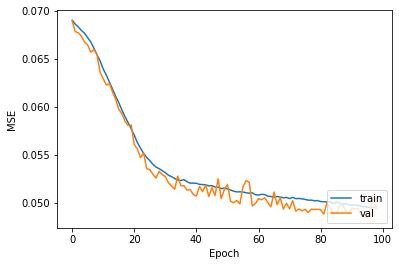

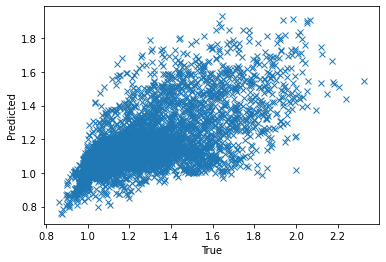

In [186]:

plt.plot(history.history['loss'][1:], label='train')#, ax=axs[0])
plt.plot(history.history['val_loss'][1:], label='val')#, ax = axs[0])
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='lower right')
plt.show()
    
y_pred = model.predict(X_valid_reshaped)
plt.plot(y_valid, model.predict(X_valid_reshaped)[:, 0], "x")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()


In [ ]:
def dialation_wave_net_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape = (32,1)))
    for i in range(1,5):
       # model.add(tf.keras.layers.Conv1D(filters=10, kernel_size = 2, padding = "causal", activation="relu", dilation_rate=i))
       # model.add(tf.keras.layers.Conv1D(filters=20, kernel_size = 2, padding = "causal", activation="relu", dilation_rate=i))
        model.add(tf.keras.layers.Conv1D(filters=32//i, kernel_size = i, activation="relu"))
    #model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(units=32, activation="relu"))
    model.add(tf.keras.layers.Dense(units=1))
    model.compile(loss="mse", optimizer = "adam", metrics=["mse"])
    print(model.summary())
    return model

dilation_model = dialation_wave_net_model()
data_directory = r"\data_set_splits_right\0"
file_list = os.listdir(data_directory)
X_train = pd.read_csv(os.path.join(data_directory, file_list[0]))
X_train.pop("Unnamed: 0")
X_valid = pd.read_csv(os.path.join(data_directory, file_list[1]))
X_valid.pop("Unnamed: 0")
y_train = np.loadtxt(os.path.join(data_directory, file_list[2]), delimiter=",")
y_valid = np.loadtxt(os.path.join(data_directory, file_list[3]), delimiter=",")
X_train = X_train.to_numpy()
X_valid = X_valid.to_numpy()
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_valid_scaled = standard_scaler.transform(X_valid)
X_train_reshaped = np.array(X_train_scaled).reshape(X_train_scaled.shape[0],32,1) 
X_valid_reshaped = np.array(X_valid_scaled).reshape(X_valid_scaled.shape[0],32,1)
print("X_train_reshaped: ", X_train_reshaped.shape)
print("X_valid_reshaped: ", X_valid_reshaped.shape)
print("y_train: ", y_train.shape)
print("y_valid: ", y_valid.shape)
print(X_valid_reshaped.shape)
# first 2 with 45 epochs
history = dilation_model.fit(x=X_train_reshaped, y=y_train, epochs=60, validation_data=(X_valid_reshaped, y_valid))
plt.plot(history.history['loss'][1:], label='train')#, ax=axs[0])
plt.plot(history.history['val_loss'][1:], label='val')#, ax = axs[0])
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='lower right')
plt.show()

y_pred = model.predict(X_valid_reshaped)
plt.plot(y_valid, model.predict(X_valid_reshaped), "x")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()


X_train_reshaped:  (84872, 32, 1)
X_valid_reshaped:  (21218, 32, 1)
y_train:  (84872,)
y_valid:  (21218,)
32
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_74 (Conv1D)           (None, 32, 32)            64        
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 29, 8)             1032      
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 22, 4)             260       
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 7, 2)              130       
_________________________________________________________________
global_average_pooling1d_6 ( (None, 2)                 0         
_________________________________________________________________
dense_28 (Dense)             (None, 32)                96        
__________

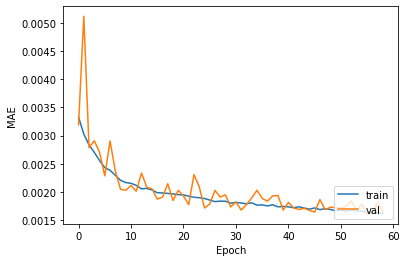

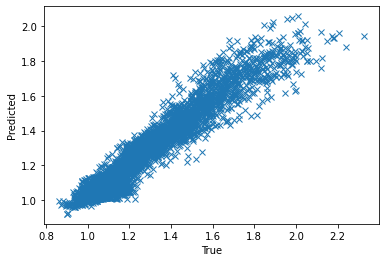

In [34]:
def build_1d_cnn_model(): # relu or not in first ler doesnt matter much
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters = 32, strides = 1, kernel_size = 1, input_shape = (32,1), activation="relu"))
    model.add(tf.keras.layers.Conv1D(filters = 8, kernel_size = 4, activation = "relu"))
    model.add(tf.keras.layers.Conv1D(filters = 4, kernel_size = 8, activation = "relu"))
    model.add(tf.keras.layers.Conv1D(filters = 2, kernel_size = 16, activation = "relu"))
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    model.add(tf.keras.layers.Dense(units = 32, activation = "relu"))
    model.add(tf.keras.layers.Dense(units = 1))
    model.compile(loss="mse", optimizer="adam", metrics=["mse"])
    print(model.summary())
    
    return model


data_directory = r"\data_set_splits_right\0"
file_list = os.listdir(data_directory)
X_train = pd.read_csv(os.path.join(data_directory, file_list[0]))
X_train.pop("Unnamed: 0")
X_valid = pd.read_csv(os.path.join(data_directory, file_list[1]))
X_valid.pop("Unnamed: 0")
y_train = np.loadtxt(os.path.join(data_directory, file_list[2]), delimiter=",")
y_valid = np.loadtxt(os.path.join(data_directory, file_list[3]), delimiter=",")
X_train = X_train.to_numpy()
X_valid = X_valid.to_numpy()
standard_scaler = StandardScaler()
X_train_scaled = standard_scaler.fit_transform(X_train)
X_valid_scaled = standard_scaler.transform(X_valid)
X_train_reshaped = np.array(X_train_scaled).reshape(X_train_scaled.shape[0],32,1) 
X_valid_reshaped = np.array(X_valid_scaled).reshape(X_valid_scaled.shape[0],32,1)
print("X_train_reshaped: ", X_train_reshaped.shape)
print("X_valid_reshaped: ", X_valid_reshaped.shape)
print("y_train: ", y_train.shape)
print("y_valid: ", y_valid.shape)

print(X_valid_reshaped.shape[1])
model = build_1d_cnn_model()
history = model.fit(x=X_train_reshaped, y=y_train, epochs=60, validation_data=(X_valid_reshaped, y_valid))
plt.plot(history.history['loss'][1:], label='train')#, ax=axs[0])
plt.plot(history.history['val_loss'][1:], label='val')#, ax = axs[0])
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend(loc='lower right')
plt.show()

y_pred = model.predict(X_valid_reshaped)
plt.plot(y_valid, model.predict(X_valid_reshaped), "x")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()


In [ ]:
for i in range(90):
    model_path_flexible = r"\models_cnn_v1_right_data\{index}.h5".format(index=str(i))
    histories_dir = r"\models_cnn_v1_right_data\histories"
    data_dir_flexible = r"\data_set_splits_right\0"
    load_train_and_safe(model_path_flexible, data_dir_flexible,histories_dir, 32)